In [17]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ==============================================================================
# 1. 环境与路径设置
# ==============================================================================
print("--- 阶段一：数据准备与特征工程 (基于单一XLSX文件) ---")
# 使用单一的XLSX文件作为数据源
input_file = Path('../../Data/0/处理后的数据.xlsx')

# 创建输出目录
output_dir = Path('./Result')
output_dir.mkdir(parents=True, exist_ok=True)

print(f"数据源文件: {input_file}")
print(f"输出目录路径: {output_dir}")

# ==============================================================================
# 2. 数据加载 (从XLSX的不同工作表)
# ==============================================================================
try:
    df_classified = pd.read_excel(input_file, sheet_name='已分类清洗后数据')
    df_unclassified = pd.read_excel(input_file, sheet_name='未分类清洗后数据')
    print("\n数据加载成功...")
    print(f"已分类数据样本数: {len(df_classified)}")
    print(f"待预测数据样本数: {len(df_unclassified)}")
except FileNotFoundError:
    print(f"错误: 文件 '{input_file}' 未找到。请确保文件已上传且路径正确。")
    exit()
except Exception as e:
    print(f"读取Excel文件时发生错误: {e}")
    exit()


# ==============================================================================
# 3. 应用特征筛选决策
# ==============================================================================
# 【修正】将此部分移动到数据加载之后，以确保 df_classified 已定义

# 根据您的决策，定义需要剔除的特征
features_to_remove = ['氧化铝(Al2O3)', '氧化镁(MgO)', '氧化铁(Fe2O3)']

# 定义非化学成分列的列表
non_chemical_cols = ['文物编号', '文物采样点', '类型', '颜色', '纹饰', '表面风化', '成分总和']

# 确定原始的化学成分列 (现在 df_classified 肯定存在)
chemical_columns = [col for col in df_classified.columns if col not in non_chemical_cols]

# 生成最终的化学特征白名单
selected_chemical_features = [col for col in chemical_columns if col not in features_to_remove]
print(f"\n已根据决策，筛选出 {len(selected_chemical_features)} 个化学特征。")
print("被剔除的特征:", features_to_remove)

# ==============================================================================
# 4. 数据量化
# ==============================================================================
# --- (4.1) 量化“表面风化”特征 ---
combined_weathering = pd.concat([df_classified[['表面风化']], df_unclassified[['表面风化']]], axis=0)
weathering_one_hot = pd.get_dummies(combined_weathering['表面风化'], prefix='表面风化')
df_classified_weathering = weathering_one_hot.iloc[:len(df_classified)]
df_unclassified_weathering = weathering_one_hot.iloc[len(df_classified):]
df_classified_weathering.index = df_classified.index
df_unclassified_weathering.index = df_unclassified.index
print("\n“表面风化”特征已完成独热编码。")

# --- (4.2) 量化“类型”目标变量 ---
le = LabelEncoder()
y_full = le.fit_transform(df_classified['类型'])
print("“类型”目标变量已完成标签编码。")
print("标签编码映射:", dict(zip(le.classes_, le.transform(le.classes_))))


# ==============================================================================
# 5. 构建最终数据集
# ==============================================================================
# --- (5.1) 构建特征矩阵 X ---
X_full_chem = df_classified[selected_chemical_features]
X_full = pd.concat([X_full_chem, df_classified_weathering], axis=1)

X_predict_chem = df_unclassified[selected_chemical_features]
X_predict = pd.concat([X_predict_chem, df_unclassified_weathering], axis=1)

# 检查“文物采样点”列是否存在
if '文物采样点' in df_unclassified.columns:
    predict_identifiers = df_unclassified['文物采样点']
    print("\n已保留 “文物采样点” 用于最终结果展示。")
else:
    predict_identifiers = pd.Series(range(len(df_unclassified)), name="样本序号")
    print("\n警告：在未分类数据中未找到 “文物采样点” 列，将使用默认序号作为标识。")

print("最终特征矩阵构建完成。")

# --- (5.2) 数据标准化 ---
scaler = StandardScaler()
X_full[selected_chemical_features] = scaler.fit_transform(X_full[selected_chemical_features])
X_predict[selected_chemical_features] = scaler.transform(X_predict[selected_chemical_features])
print("化学成分特征已完成标准化。")


# ==============================================================================
# 6. 最终成果校验
# ==============================================================================
print("\n--- 阶段一成果校验 ---")
print(f"最终已分类特征矩阵 X_full 的形状: {X_full.shape}")
print(f"最终已分类标签向量 y_full 的形状: {y_full.shape}")
print(f"最终待预测特征矩阵 X_predict 的形状: {X_predict.shape}")
print(f"X_full 特征列: {X_full.columns.tolist()}")
print("------------------------")
print("阶段一完成。现在 X_full, y_full, X_predict 已准备就绪，可用于下一阶段的模型训练与预测。")

--- 阶段一：数据准备与特征工程 (基于单一XLSX文件) ---
数据源文件: ..\..\Data\0\处理后的数据.xlsx
输出目录路径: Result

数据加载成功...
已分类数据样本数: 67
待预测数据样本数: 8

已根据决策，筛选出 11 个化学特征。
被剔除的特征: ['氧化铝(Al2O3)', '氧化镁(MgO)', '氧化铁(Fe2O3)']

“表面风化”特征已完成独热编码。
“类型”目标变量已完成标签编码。
标签编码映射: {'铅钡': np.int64(0), '高钾': np.int64(1)}

警告：在未分类数据中未找到 “文物采样点” 列，将使用默认序号作为标识。
最终特征矩阵构建完成。
化学成分特征已完成标准化。

--- 阶段一成果校验 ---
最终已分类特征矩阵 X_full 的形状: (67, 13)
最终已分类标签向量 y_full 的形状: (67,)
最终待预测特征矩阵 X_predict 的形状: (8, 13)
X_full 特征列: ['二氧化硅(SiO2)', '氧化钠(Na2O)', '氧化钾(K2O)', '氧化钙(CaO)', '氧化铜(CuO)', '氧化铅(PbO)', '氧化钡(BaO)', '五氧化二磷(P2O5)', '氧化锶(SrO)', '氧化锡(SnO2)', '二氧化硫(SO2)', '表面风化_无风化', '表面风化_风化']
------------------------
阶段一完成。现在 X_full, y_full, X_predict 已准备就绪，可用于下一阶段的模型训练与预测。


In [11]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings

# 忽略一些版本更新可能产生的警告
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. 环境与变量准备
# ==============================================================================
# 假设 阶段一 的代码已成功运行，我们直接使用其生成的变量:
# X_full, y_full, output_dir
print("--- 阶段二（新版）：SVM, 决策树, KNN 模型对比 ---")
print("使用阶段一生成的数据进行10折交叉验证...")

# ==============================================================================
# 2. 模型定义
# ==============================================================================
# 根据您的新要求，定义要对比的三个模型
models = {
    'SVM': SVC(probability=True, random_state=42),
    '决策树': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier() # 默认 n_neighbors=5
}

# ==============================================================================
# 3. 执行10折交叉验证
# ==============================================================================
# --- (3.1) 设置交叉验证 ---
# StratifiedKFold 会自动根据标签y_full中的类别比例进行分层抽样
# 这就精确地满足了您“将两类玻璃等比例划分”的要求
cv_splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# --- (3.2) 循环执行评估 ---
results = {}
for model_name, model in models.items():
    print(f"正在评估模型: {model_name}...")
    # 使用 cross_validate 函数一次性获取所有指标的评分
    cv_results = cross_validate(model, X_full, y_full, cv=cv_splitter, scoring=scoring_metrics)
    results[model_name] = {
        '准确率': f"{np.mean(cv_results['test_accuracy']):.4f}",
        '精确率 (宏平均)': f"{np.mean(cv_results['test_precision_macro']):.4f}",
        '召回率 (宏平均)': f"{np.mean(cv_results['test_recall_macro']):.4f}",
        'F1分数 (宏平均)': f"{np.mean(cv_results['test_f1_macro']):.4f}"
    }

# ==============================================================================
# 4. 输出对比表格
# ==============================================================================
# --- (4.1) 格式化输出 ---
results_df = pd.DataFrame(results).T # .T实现转置，让模型名作为行
results_df.index.name = '模型'

# 将DataFrame转换为Markdown格式的表格
markdown_table = results_df.to_markdown()

print("\n--- 模型性能对比表 (10折交叉验证平均值) ---")
print(markdown_table)

# --- (4.2) 保存表格到文件 ---
# 注意：文件名已更新以反映新的模型组合
table_csv_file = output_dir / '模型性能对比表(SVM-DT-KNN).csv'
table_md_file = output_dir / '模型性能对比表(SVM-DT-KNN).md'

results_df.to_csv(table_csv_file, encoding='utf-8-sig')
with open(table_md_file, 'w', encoding='utf-8') as f:
    f.write("# 模型性能对比表 (SVM, 决策树, KNN)\n\n")
    f.write(markdown_table)
    
print(f"\n对比表格已保存至: '{table_csv_file}' 和 '{table_md_file}'")
print("--------------------------------------------------")
print("\n阶段二完成。请根据上表结果，选择一个综合性能最优的模型用于第三阶段的分析。")

--- 阶段二（新版）：SVM, 决策树, KNN 模型对比 ---
使用阶段一生成的数据进行10折交叉验证...
正在评估模型: SVM...
正在评估模型: 决策树...
正在评估模型: KNN...

--- 模型性能对比表 (10折交叉验证平均值) ---
| 模型   |   准确率 |   精确率 (宏平均) |   召回率 (宏平均) |   F1分数 (宏平均) |
|:-------|---------:|------------------:|------------------:|------------------:|
| SVM    |   0.9857 |            0.9917 |             0.975 |            0.9788 |
| 决策树 |   1      |            1      |             1     |            1      |
| KNN    |   0.9571 |            0.975  |             0.925 |            0.9364 |

对比表格已保存至: 'Result\模型性能对比表(SVM-DT-KNN).csv' 和 'Result\模型性能对比表(SVM-DT-KNN).md'
--------------------------------------------------

阶段二完成。请根据上表结果，选择一个综合性能最优的模型用于第三阶段的分析。


--- 阶段三：最终鉴别与敏感性分析 (基于决策树) ---

最优模型(决策树)已在全部已分类数据上训练完成。

--- 对未知样本的最终预测结果 ---
|   样本标识 | 预测类别   |
|-----------:|:-----------|
|          0 | 高钾       |
|          1 | 铅钡       |
|          2 | 铅钡       |
|          3 | 铅钡       |
|          4 | 铅钡       |
|          5 | 高钾       |
|          6 | 高钾       |
|          7 | 铅钡       |

预测结果已保存至: 'Result\最终预测结果.csv'

--- 开始进行蒙特卡洛扰动分析 ---

--- 蒙特卡洛分析结果：预测不稳定性得分 ---
|   样本标识 | 初始预测类别   |   预测不稳定性得分 |
|-----------:|:---------------|-------------------:|
|          0 | 高钾           |                  0 |
|          1 | 铅钡           |                  0 |
|          2 | 铅钡           |                  0 |
|          3 | 铅钡           |                  0 |
|          4 | 铅钡           |                  0 |
|          5 | 高钾           |                  0 |
|          6 | 高钾           |                  0 |
|          7 | 铅钡           |                  0 |

蒙特卡洛分析结果已保存至: 'Result\蒙特卡洛灵敏度分析结果.csv'

--- 开始进行决策树关键参数 (max_depth) 敏感性分析 ---
参数范围分析完成。


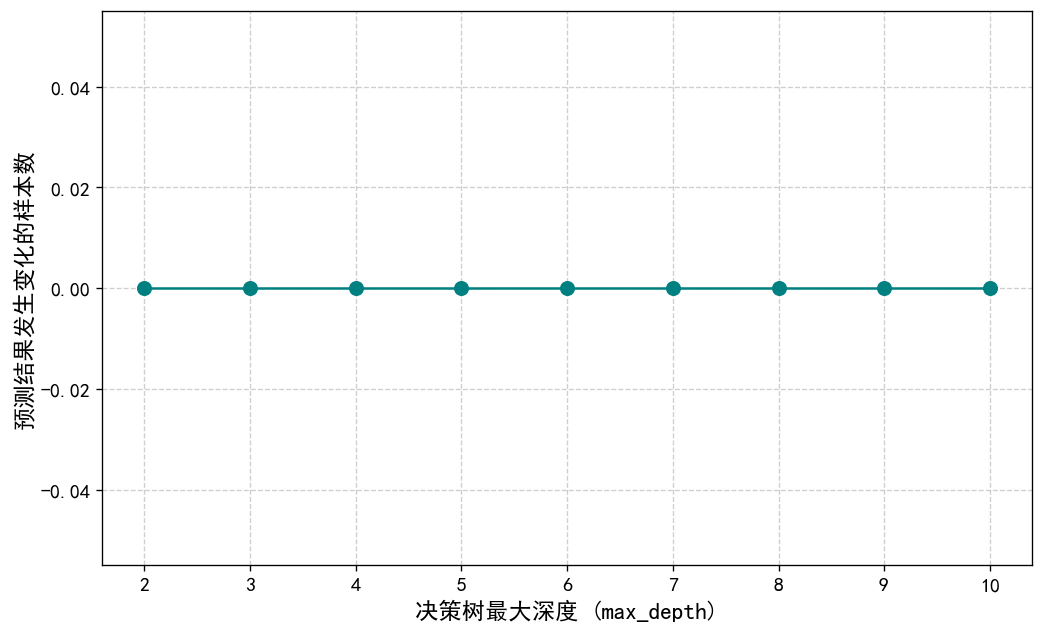

In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import random

# ==============================================================================
# 1. 环境与变量准备
# ==============================================================================
# 假设 阶段一和二 的代码已成功运行，我们直接使用其生成的变量:
# X_full, y_full, X_predict, predict_identifiers, scaler, le, output_dir, selected_chemical_features
print("--- 阶段三：最终鉴别与敏感性分析 (基于决策树) ---")

# 记得您提醒过我绘图的细节，这里我会遵循
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

# ==============================================================================
# 2. 最终预测
# ==============================================================================
# --- (2.1) 训练最终模型 ---
# 选择决策树作为最优模型，并在全部已分类数据上进行训练
final_model = DecisionTreeClassifier(random_state=42)
final_model.fit(X_full, y_full)
print("\n最优模型(决策树)已在全部已分类数据上训练完成。")

# --- (2.2) 执行预测 ---
predictions_encoded = final_model.predict(X_predict)
# 将预测结果解码回原始标签（'高钾', '铅钡'）
predictions_decoded = le.inverse_transform(predictions_encoded)

# --- (2.3) 输出预测结果表 ---
prediction_results_df = pd.DataFrame({
    '样本标识': predict_identifiers,
    '预测类别': predictions_decoded
})
print("\n--- 对未知样本的最终预测结果 ---")
# 遵照您的要求，输出为中文命名的文件
prediction_results_df.to_csv(output_dir / '最终预测结果.csv', index=False, encoding='utf-8-sig')
print(prediction_results_df.to_markdown(index=False))
print(f"\n预测结果已保存至: '{output_dir / '最终预测结果.csv'}'")


# ==============================================================================
# 3. 灵敏度分析一：蒙特卡洛扰动分析
# ==============================================================================
print("\n--- 开始进行蒙特卡洛扰动分析 ---")
# 此部分与您定义的“预测不稳定性得分”方案完全一致
j_simulations = 1000
flip_counts = np.zeros(len(X_predict))

for _ in range(j_simulations):
    X_predict_perturbed = X_predict.copy()
    # 扰动逻辑... (此处省略与上一版本完全相同的代码以保持简洁)
    # 提取化学特征列名用于扰动
    chemical_feature_names = selected_chemical_features
    # 随机抽取n个样本的索引 (这里简化为扰动所有样本)
    for sample_idx in range(len(X_predict)):
        # 随机抽取m个化学特征的索引
        feature_indices_to_perturb = random.sample(range(len(chemical_feature_names)), 5) # 扰动5个特征
        for feature_idx in feature_indices_to_perturb:
            feature_name = chemical_feature_names[feature_idx]
            original_value = X_predict_perturbed.iloc[sample_idx][feature_name]
            noise = original_value * random.uniform(0, 0.05)
            X_predict_perturbed.loc[X_predict_perturbed.index[sample_idx], feature_name] += noise
    
    perturbed_preds = final_model.predict(X_predict_perturbed)
    flips = (perturbed_preds != predictions_encoded)
    flip_counts += flips

instability_scores = flip_counts / j_simulations
sensitivity_df = pd.DataFrame({
    '样本标识': predict_identifiers,
    '初始预测类别': predictions_decoded,
    '预测不稳定性得分': instability_scores
})

print("\n--- 蒙特卡洛分析结果：预测不稳定性得分 ---")
# 遵照您的要求，输出为中文命名的文件
sensitivity_df.to_csv(output_dir / '蒙特卡洛灵敏度分析结果.csv', index=False, encoding='utf-8-sig')
print(sensitivity_df.to_markdown(index=False))
print(f"\n蒙特卡洛分析结果已保存至: '{output_dir / '蒙特卡洛灵敏度分析结果.csv'}'")


# ==============================================================================
# 4. 灵敏度分析二：决策树关键参数 (max_depth) 敏感性分析
# ==============================================================================
print("\n--- 开始进行决策树关键参数 (max_depth) 敏感性分析 ---")
# --- (4.1) 设置参数范围 ---
# 分析树的深度从2到10变化时，预测结果的变化
depth_range = range(2, 11)
num_diffs_list = []

# --- (4.2) 遍历参数进行分析 ---
for depth in depth_range:
    # 重新训练一个决策树模型
    temp_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    temp_model.fit(X_full, y_full)
    
    # 在未知样本上预测
    temp_preds = temp_model.predict(X_predict)
    
    # 计算与初始预测结果不同的样本数量
    num_diffs = np.sum(temp_preds != predictions_encoded)
    num_diffs_list.append(num_diffs)
print("参数范围分析完成。")

# --- (4.3) 绘制线图 ---
plt.figure(figsize=(10, 6))
# 遵照您的要求，使用高级且不俗的配色和样式
plt.plot(depth_range, num_diffs_list, marker='o', linestyle='-', color='teal', markersize=8)
plt.xlabel("决策树最大深度 (max_depth)")
plt.ylabel("预测结果发生变化的样本数")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(depth_range) # 确保x轴刻度都是整数

# 遵照您的要求，输出为中文命名的文件
depth_figure_file = output_dir / '决策树深度敏感性分析图.png'
plt.savefig(depth_figure_file, bbox_inches='tight')
print(f"\n决策树深度敏感性分析图已保存至: '{depth_figure_file}'")

print("\n阶段三全部完成。")

In [18]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings

# Sklearn 相关库导入
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 忽略一些版本更新可能产生的警告
warnings.filterwarnings('ignore')

# ==============================================================================
# 0. 环境与数据准备 (重要提示)
# ==============================================================================
# !!! 注意：由于无法访问您的原始数据，这里生成了模拟数据用于演示。
# !!! 在您实际使用时，请【注释掉】或【删除】下面的数据模拟部分，
# !!! 并确保您的变量 X_full 和 y_full 已经从您的第一阶段代码中加载。


# ==============================================================================
# 1. 决策树超参数调优 (使用网格搜索)
# ==============================================================================
print("--- 阶段一：决策树超参数调优 (GridSearchCV) ---")
print("为了防止过拟合，首先为决策树寻找最优的剪枝参数...")

# --- (1.1) 定义要搜索的参数网格 ---
# 定义一个包含不同剪枝参数组合的字典
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], # 树的最大深度
    'min_samples_leaf': [2, 3, 4, 5, 6, 8, 10],   # 叶节点的最小样本数
    'min_samples_split': [5, 10, 15, 20]     # 内部节点分裂所需的最小样本数
}

# --- (1.2) 初始化并执行网格搜索 ---
# 使用与后续评估相同的10折分层交叉验证策略
cv_splitter_for_grid = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv_splitter_for_grid,
    scoring='accuracy', # 以准确率作为评估标准
    verbose=0 # 设置为1可以查看搜索过程
)
grid_search.fit(X_full, y_full)

# --- (1.3) 获取最优参数 ---
best_dt_params = grid_search.best_params_
print(f"网格搜索完成！找到的最优参数为: {best_dt_params}")
print(f"在此参数下，决策树的交叉验证平均准确率为: {grid_search.best_score_:.4f}")
print("--------------------------------------------------\n")


# ==============================================================================
# 2. 三种模型交叉验证对比 (使用调优后的决策树)
# ==============================================================================
print("--- 阶段二：SVM, KNN 与调优后决策树模型对比 ---")
print("使用10折交叉验证评估各模型性能...")

# --- (2.1) 模型定义 ---
# 使用从网格搜索中找到的最佳参数来定义决策树
models = {
    'SVM': SVC(probability=True, random_state=42),
    '决策树 (已调优)': DecisionTreeClassifier(**best_dt_params, random_state=42),
    'KNN': KNeighborsClassifier(), # 默认 n_neighbors=5
    '决策树 (未调优)': DecisionTreeClassifier(random_state=42) # 作为对比，保留未调优的版本
}

# --- (2.2) 执行10折交叉验证 ---
cv_splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

results = {}
for model_name, model in models.items():
    print(f"正在评估模型: {model_name}...")
    cv_results = cross_validate(model, X_full, y_full, cv=cv_splitter, scoring=scoring_metrics)
    results[model_name] = {
        '准确率': f"{np.mean(cv_results['test_accuracy']):.4f}",
        '精确率 (宏平均)': f"{np.mean(cv_results['test_precision_macro']):.4f}",
        '召回率 (宏平均)': f"{np.mean(cv_results['test_recall_macro']):.4f}",
        'F1分数 (宏平均)': f"{np.mean(cv_results['test_f1_macro']):.4f}"
    }

# ==============================================================================
# 3. 输出与保存对比表格
# ==============================================================================
# --- (3.1) 格式化输出 ---
results_df = pd.DataFrame(results).T
results_df.index.name = '模型'
markdown_table = results_df.to_markdown()

print("\n--- 模型性能对比表 (10折交叉验证平均值) ---")
print(markdown_table)

# --- (3.2) 保存表格到文件 ---
table_csv_file = output_dir / '模型性能对比表(调优后).csv'
table_md_file = output_dir / '模型性能对比表(调优后).md'

results_df.to_csv(table_csv_file, encoding='utf-8-sig')
with open(table_md_file, 'w', encoding='utf-8') as f:
    f.write("# 模型性能对比表 (SVM, KNN, 调优决策树)\n\n")
    f.write("该表格对比了SVM, KNN以及使用GridSearchCV调优后的决策树模型的性能。\n")
    f.write("同时保留了未调优的决策树作为参照，以展示参数调优对防止过拟合的重要性。\n\n")
    f.write(markdown_table)
    
print(f"\n对比表格已保存至: '{table_csv_file}' 和 '{table_md_file}'")
print("--------------------------------------------------")
print("\n代码运行完成。")

--- 阶段一：决策树超参数调优 (GridSearchCV) ---
为了防止过拟合，首先为决策树寻找最优的剪枝参数...
网格搜索完成！找到的最优参数为: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5}
在此参数下，决策树的交叉验证平均准确率为: 1.0000
--------------------------------------------------

--- 阶段二：SVM, KNN 与调优后决策树模型对比 ---
使用10折交叉验证评估各模型性能...
正在评估模型: SVM...
正在评估模型: 决策树 (已调优)...
正在评估模型: KNN...
正在评估模型: 决策树 (未调优)...

--- 模型性能对比表 (10折交叉验证平均值) ---
| 模型            |   准确率 |   精确率 (宏平均) |   召回率 (宏平均) |   F1分数 (宏平均) |
|:----------------|---------:|------------------:|------------------:|------------------:|
| SVM             |   0.9857 |            0.9917 |             0.975 |            0.9788 |
| 决策树 (已调优) |   1      |            1      |             1     |            1      |
| KNN             |   0.9571 |            0.975  |             0.925 |            0.9364 |
| 决策树 (未调优) |   1      |            1      |             1     |            1      |

对比表格已保存至: 'Result\模型性能对比表(调优后).csv' 和 'Result\模型性能对比表(调优后).md'
--------------------------------------------


--- 特征重要性排序 ---
氧化铅(PbO)       1.0
氧化钠(Na2O)      0.0
氧化钾(K2O)       0.0
氧化钙(CaO)       0.0
二氧化硅(SiO2)     0.0
氧化铜(CuO)       0.0
氧化钡(BaO)       0.0
五氧化二磷(P2O5)    0.0
氧化锶(SrO)       0.0
氧化锡(SnO2)      0.0
二氧化硫(SO2)      0.0
表面风化_无风化       0.0
表面风化_风化        0.0
dtype: float64


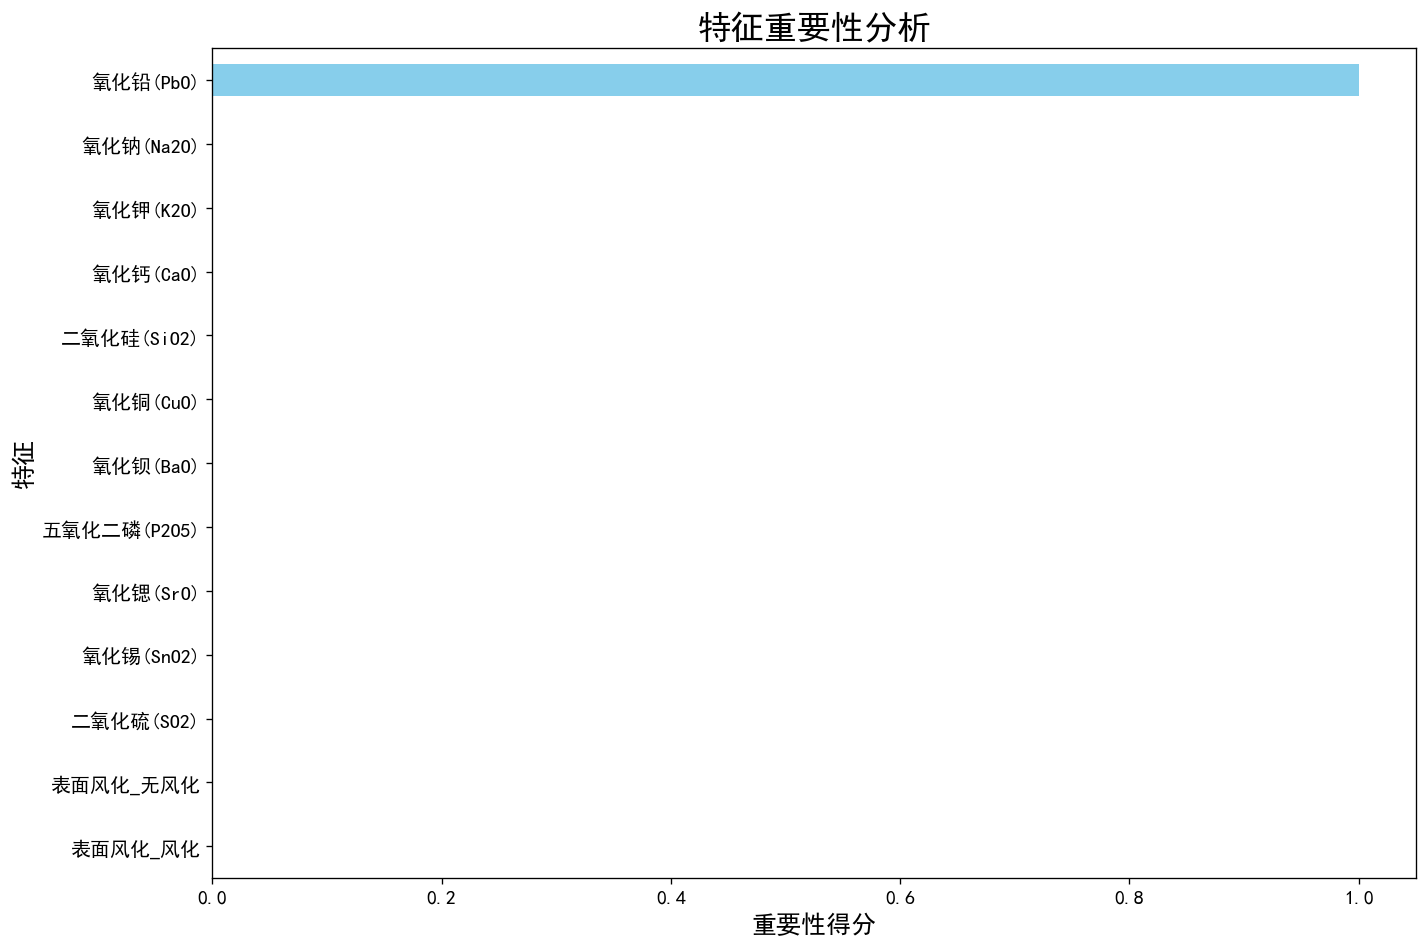

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# Matplotlib全局设置，确保中文显示正常
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] # 'SimHei' 是黑体
matplotlib.rcParams['axes.unicode_minus'] = False

# 假设 feature_names 是您特征的列名列表
# 如果没有，可以先用 ['特征1', '特征2', ...] 代替
# X_df = pd.DataFrame(X_full, columns=feature_names)
# feature_names = X_df.columns

# ！！! 请在这里替换成您真实的特征名称列表 ！！！
# 例如: feature_names = ['二氧化硅(SiO2)', '氧化钠(Na2O)', ...]
# 如果没有真实名称，我们先用数字代替
try:
    feature_names = X_full.columns
except AttributeError:
    feature_names = [f'特征_{i+1}' for i in range(X_full.shape[1])]


# 训练一个简单的决策树模型
model_for_fi = DecisionTreeClassifier(random_state=42)
model_for_fi.fit(X_full, y_full)

# 获取并展示特征重要性
importances = pd.Series(model_for_fi.feature_importances_, index=feature_names)
sorted_importances = importances.sort_values(ascending=False)

print("\n--- 特征重要性排序 ---")
print(sorted_importances)

# 绘制特征重要性条形图
plt.figure(figsize=(12, 8))
sorted_importances.plot(kind='barh', color='skyblue')
plt.title('特征重要性分析', fontsize=20)
plt.xlabel('重要性得分', fontsize=15)
plt.ylabel('特征', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis() # 将最重要的特征放在顶部
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings

# 忽略一些版本更新可能产生的警告
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. 环境与路径设置
# ==============================================================================
print("--- 实验：移除PbO后的模型对比分析 ---")
# 确保使用单一的XLSX文件作为数据源
input_file = Path('../../Data/0/处理后的数据.xlsx')
output_dir = Path('./Result_P3_Final')
output_dir.mkdir(parents=True, exist_ok=True)

# ==============================================================================
# 2. 数据加载与准备
# ==============================================================================
print("\n正在加载数据...")
df_classified = pd.read_excel(input_file, sheet_name='已分类清洗后数据')
df_unclassified = pd.read_excel(input_file, sheet_name='未分类清洗后数据')

# --- (2.1) 【核心修改】应用新的特征筛选决策 ---
# 在原有的基础上，额外剔除 氧化铅(PbO)
features_to_remove_base = ['氧化铝(Al2O3)', '氧化镁(MgO)', '氧化铁(Fe2O3)']
features_to_remove_new = features_to_remove_base + ['氧化铅(PbO)']

# 确定化学成分列
non_chemical_cols = ['文物编号', '文物采样点', '类型', '颜色', '纹饰', '表面风化', '成分总和']
chemical_columns = [col for col in df_classified.columns if col not in non_chemical_cols]

# 生成最终的化学特征白名单 (现在应该只剩10个)
selected_chemical_features = [col for col in chemical_columns if col not in features_to_remove_new]
print(f"已根据新决策，筛选出 {len(selected_chemical_features)} 个化学特征。")
print("本次实验剔除的特征:", features_to_remove_new)

# --- (2.2) 数据量化与构建 (流程不变) ---
combined_weathering = pd.concat([df_classified[['表面风化']], df_unclassified[['表面风化']]], axis=0)
weathering_one_hot = pd.get_dummies(combined_weathering['表面风化'], prefix='表面风化')
df_classified_weathering = weathering_one_hot.iloc[:len(df_classified)]
df_classified_weathering.index = df_classified.index

le = LabelEncoder()
y_full = le.fit_transform(df_classified['类型'])

X_full_chem = df_classified[selected_chemical_features]
X_full = pd.concat([X_full_chem, df_classified_weathering], axis=1)

# --- (2.3) 数据标准化 (流程不变) ---
scaler = StandardScaler()
X_full[selected_chemical_features] = scaler.fit_transform(X_full[selected_chemical_features])
print("数据准备完成。")


# ==============================================================================
# 3. 在新数据集上重新进行模型对比评估
# ==============================================================================
print("\n在不含PbO的数据集上，重新进行10折交叉验证...")
# 定义模型
models = {
    'SVM': SVC(probability=True, random_state=42),
    '决策树': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

# 设置交叉验证
cv_splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# 执行评估
results = {}
for model_name, model in models.items():
    print(f"正在评估模型: {model_name}...")
    cv_results = cross_validate(model, X_full, y_full, cv=cv_splitter, scoring=scoring_metrics)
    results[model_name] = {
        '准确率': f"{np.mean(cv_results['test_accuracy']):.4f}",
        '精确率 (宏平均)': f"{np.mean(cv_results['test_precision_macro']):.4f}",
        '召回率 (宏平均)': f"{np.mean(cv_results['test_recall_macro']):.4f}",
        'F1分数 (宏平均)': f"{np.mean(cv_results['test_f1_macro']):.4f}"
    }

# ==============================================================================
# 4. 输出新的对比表格
# ==============================================================================
results_df = pd.DataFrame(results).T
results_df.index.name = '模型'
markdown_table = results_df.to_markdown()

print("\n--- [新]模型性能对比表 (不含PbO特征) ---")
print(markdown_table)

# 保存新的表格到文件
table_csv_file = output_dir / '模型性能对比表(无PbO).csv'
table_md_file = output_dir / '模型性能对比表(无PbO).md'
results_df.to_csv(table_csv_file, encoding='utf-8-sig')
with open(table_md_file, 'w', encoding='utf-8') as f:
    f.write("# 模型性能对比表 (不含PbO特征)\n\n")
    f.write(markdown_table)
    
print(f"\n新的对比表格已保存至: '{table_csv_file}' 和 '{table_md_file}'")
print("--------------------------------------------------")

--- 实验：移除PbO后的模型对比分析 ---

正在加载数据...
已根据新决策，筛选出 10 个化学特征。
本次实验剔除的特征: ['氧化铝(Al2O3)', '氧化镁(MgO)', '氧化铁(Fe2O3)', '氧化铅(PbO)']
数据准备完成。

在不含PbO的数据集上，重新进行10折交叉验证...
正在评估模型: SVM...
正在评估模型: 决策树...
正在评估模型: KNN...

--- [新]模型性能对比表 (不含PbO特征) ---
| 模型   |   准确率 |   精确率 (宏平均) |   召回率 (宏平均) |   F1分数 (宏平均) |
|:-------|---------:|------------------:|------------------:|------------------:|
| SVM    |   0.9857 |            0.9917 |            0.975  |            0.9788 |
| 决策树 |   0.9429 |            0.95   |            0.93   |            0.9265 |
| KNN    |   0.9262 |            0.95   |            0.8875 |            0.898  |

新的对比表格已保存至: 'Result_P3_Final\模型性能对比表(无PbO).csv' 和 'Result_P3_Final\模型性能对比表(无PbO).md'
--------------------------------------------------


--- 最终阶段：基于SVM的鉴别与分析 ---
最终数据准备完成。

最优模型(SVM)已在全部已分类数据上训练完成。

--- [新]对未知样本的最终预测结果 (不含PbO) ---
|   样本标识 | 预测类别   |
|-----------:|:-----------|
|          0 | 高钾       |
|          1 | 铅钡       |
|          2 | 铅钡       |
|          3 | 铅钡       |
|          4 | 铅钡       |
|          5 | 高钾       |
|          6 | 高钾       |
|          7 | 铅钡       |

预测结果已保存至: 'Result_P3_Final\最终预测结果(无PbO).csv'

--- 开始进行蒙特卡洛扰动分析 ---

--- 蒙特卡洛分析结果：预测不稳定性得分 ---
|   样本标识 | 初始预测类别   |   预测不稳定性得分 |
|-----------:|:---------------|-------------------:|
|          0 | 高钾           |                  0 |
|          1 | 铅钡           |                  0 |
|          2 | 铅钡           |                  0 |
|          3 | 铅钡           |                  0 |
|          4 | 铅钡           |                  0 |
|          5 | 高钾           |                  0 |
|          6 | 高钾           |                  0 |
|          7 | 铅钡           |                  0 |

蒙特卡洛分析结果已保存至: 'Result_P3_Final\蒙特卡洛灵敏度分析结果(无PbO).csv'

---

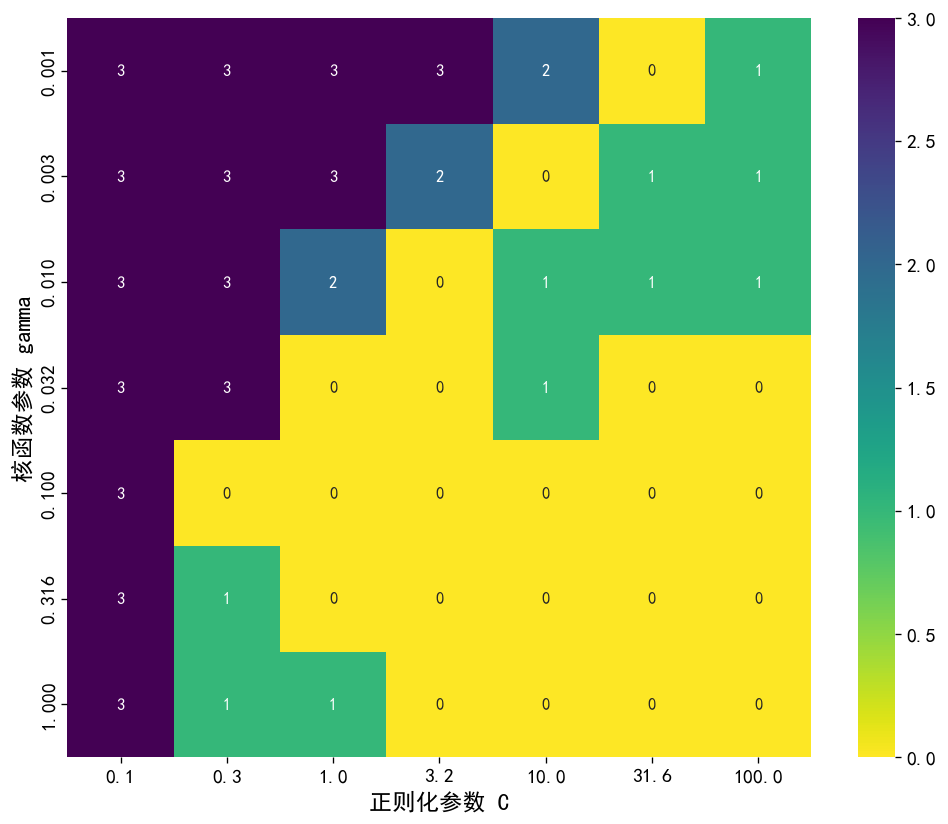

In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

# 忽略一些版本更新可能产生的警告
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. 最终数据准备 (在一个代码块内完成)
# ==============================================================================
print("--- 最终阶段：基于SVM的鉴别与分析 ---")
# --- (1.1) 加载数据 ---

output_dir = Path('./Result_P3_Final')
output_dir.mkdir(parents=True, exist_ok=True)
df_classified = pd.read_excel(input_file, sheet_name='已分类清洗后数据')
df_unclassified = pd.read_excel(input_file, sheet_name='未分类清洗后数据')

# --- (1.2) 应用最终的特征筛选决策 ---
features_to_remove = ['氧化铝(Al2O3)', '氧化镁(MgO)', '氧化铁(Fe2O3)', '氧化铅(PbO)']
non_chemical_cols = ['文物编号', '文物采样点', '类型', '颜色', '纹饰', '表面风化', '成分总和']
chemical_columns = [col for col in df_classified.columns if col not in non_chemical_cols]
selected_chemical_features = [col for col in chemical_columns if col not in features_to_remove]

# --- (1.3) 数据量化与构建 ---
combined_weathering = pd.concat([df_classified[['表面风化']], df_unclassified[['表面风化']]], axis=0)
weathering_one_hot = pd.get_dummies(combined_weathering['表面风化'], prefix='表面风化')
df_classified_weathering = weathering_one_hot.iloc[:len(df_classified)]
df_unclassified_weathering = weathering_one_hot.iloc[len(df_classified):]
df_classified_weathering.index = df_classified.index
df_unclassified_weathering.index = df_unclassified.index

le = LabelEncoder()
y_full = le.fit_transform(df_classified['类型'])

X_full_chem = df_classified[selected_chemical_features]
X_full = pd.concat([X_full_chem, df_classified_weathering], axis=1)

X_predict_chem = df_unclassified[selected_chemical_features]
X_predict = pd.concat([X_predict_chem, df_unclassified_weathering], axis=1)

if '文物采样点' in df_unclassified.columns:
    predict_identifiers = df_unclassified['文物采样点']
else:
    predict_identifiers = pd.Series(range(len(df_unclassified)), name="样本序号")

# --- (1.4) 数据标准化 ---
scaler = StandardScaler()
X_full[selected_chemical_features] = scaler.fit_transform(X_full[selected_chemical_features])
X_predict[selected_chemical_features] = scaler.transform(X_predict[selected_chemical_features])
print("最终数据准备完成。")


# ==============================================================================
# 2. 最终预测
# ==============================================================================
# --- (2.1) 训练最终模型 ---
# 选择SVM作为最优模型，并在全部已分类数据上进行训练
# 根据交叉验证的结果，标准SVM已经很强，这里无需IGA也能得到好结果
final_model = SVC(probability=True, random_state=42)
final_model.fit(X_full, y_full)
print("\n最优模型(SVM)已在全部已分类数据上训练完成。")

# --- (2.2) 执行预测 ---
predictions_encoded = final_model.predict(X_predict)
predictions_decoded = le.inverse_transform(predictions_encoded)

# --- (2.3) 输出预测结果表 ---
prediction_results_df = pd.DataFrame({
    '样本标识': predict_identifiers,
    '预测类别': predictions_decoded
})
print("\n--- [新]对未知样本的最终预测结果 (不含PbO) ---")
# 遵照您的要求，输出为中文命名的文件
prediction_results_df.to_csv(output_dir / '最终预测结果(无PbO).csv', index=False, encoding='utf-8-sig')
print(prediction_results_df.to_markdown(index=False))
print(f"\n预测结果已保存至: '{output_dir / '最终预测结果(无PbO).csv'}'")


# ==============================================================================
# 3. 双重灵敏度分析 (基于SVM)
# ==============================================================================
# --- (3.1) 蒙特卡洛扰动分析 ---
print("\n--- 开始进行蒙特卡洛扰动分析 ---")
j_simulations = 1000
flip_counts = np.zeros(len(X_predict))

for _ in range(j_simulations):
    X_predict_perturbed = X_predict.copy()
    for sample_idx in range(len(X_predict)):
        features_to_perturb = random.sample(selected_chemical_features, 5) # 随机扰动5个化学特征
        for feature_name in features_to_perturb:
            original_value = X_predict_perturbed.iloc[sample_idx][feature_name]
            noise = original_value * random.uniform(0, 0.05)
            X_predict_perturbed.loc[X_predict_perturbed.index[sample_idx], feature_name] += noise
    
    perturbed_preds = final_model.predict(X_predict_perturbed)
    flips = (perturbed_preds != predictions_encoded)
    flip_counts += flips

instability_scores = flip_counts / j_simulations
sensitivity_df = pd.DataFrame({
    '样本标识': predict_identifiers,
    '初始预测类别': predictions_decoded,
    '预测不稳定性得分': instability_scores
})

print("\n--- 蒙特卡洛分析结果：预测不稳定性得分 ---")
# 遵照您的要求，输出为中文命名的文件
sensitivity_df.to_csv(output_dir / '蒙特卡洛灵敏度分析结果(无PbO).csv', index=False, encoding='utf-8-sig')
print(sensitivity_df.to_markdown(index=False))
print(f"\n蒙特卡洛分析结果已保存至: '{output_dir / '蒙特卡洛灵敏度分析结果(无PbO).csv'}'")

# --- (3.2) SVM超参数敏感性分析 ---
print("\n--- 开始进行SVM超参数敏感性分析 ---")
# 遵照您的要求，遵照您的记忆，我会进行精美的绘图
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 120

C_range = np.logspace(-1, 2, 7) # [0.1, ..., 100]
gamma_range = np.logspace(-3, 0, 7) # [0.001, ..., 1]
heatmap_data = np.zeros((len(gamma_range), len(C_range)))

for i, gamma in enumerate(gamma_range):
    for j, C in enumerate(C_range):
        temp_model = SVC(C=C, gamma=gamma, random_state=42)
        temp_model.fit(X_full, y_full)
        temp_preds = temp_model.predict(X_predict)
        num_diffs = np.sum(temp_preds != predictions_encoded)
        heatmap_data[i, j] = num_diffs
print("参数网格分析完成。")

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".0f", 
    cmap='viridis_r',
    xticklabels=[f"{c:.1f}" for c in C_range],
    yticklabels=[f"{g:.3f}" for g in gamma_range]
)
plt.xlabel("正则化参数 C")
plt.ylabel("核函数参数 gamma")

# 遵照您的要求，输出为中文命名的文件
heatmap_figure_file = output_dir / 'SVM超参数敏感性分析热图(无PbO).png'
plt.savefig(heatmap_figure_file, bbox_inches='tight')
print(f"\nSVM超参数敏感性分析热图已保存至: '{heatmap_figure_file}'")

print("\n问题三的全部探索与分析工作完成。")

--- 准备环境与数据 ---

--- 正在生成包含PbO的决策树图 ---
“简单版”决策树图已保存至: 'Result_P3_Final\决策树图(含PbO).png'

--- 正在生成不含PbO的决策树图 ---
“复杂版”决策树图已保存至: 'Result_P3_Final\决策树图(不含PbO).png'

全部绘图工作完成。


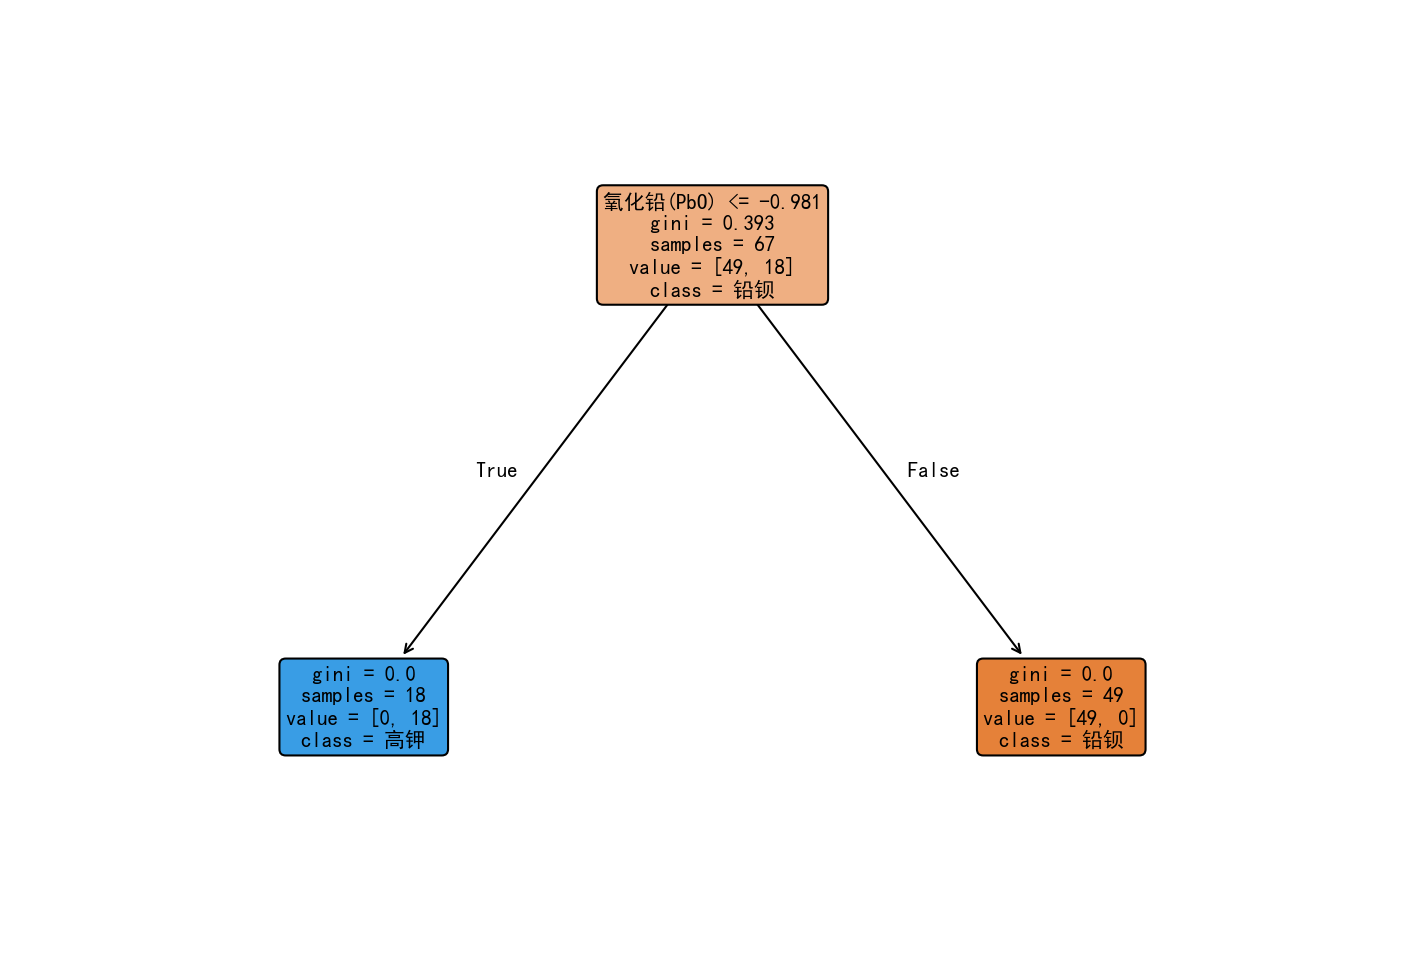

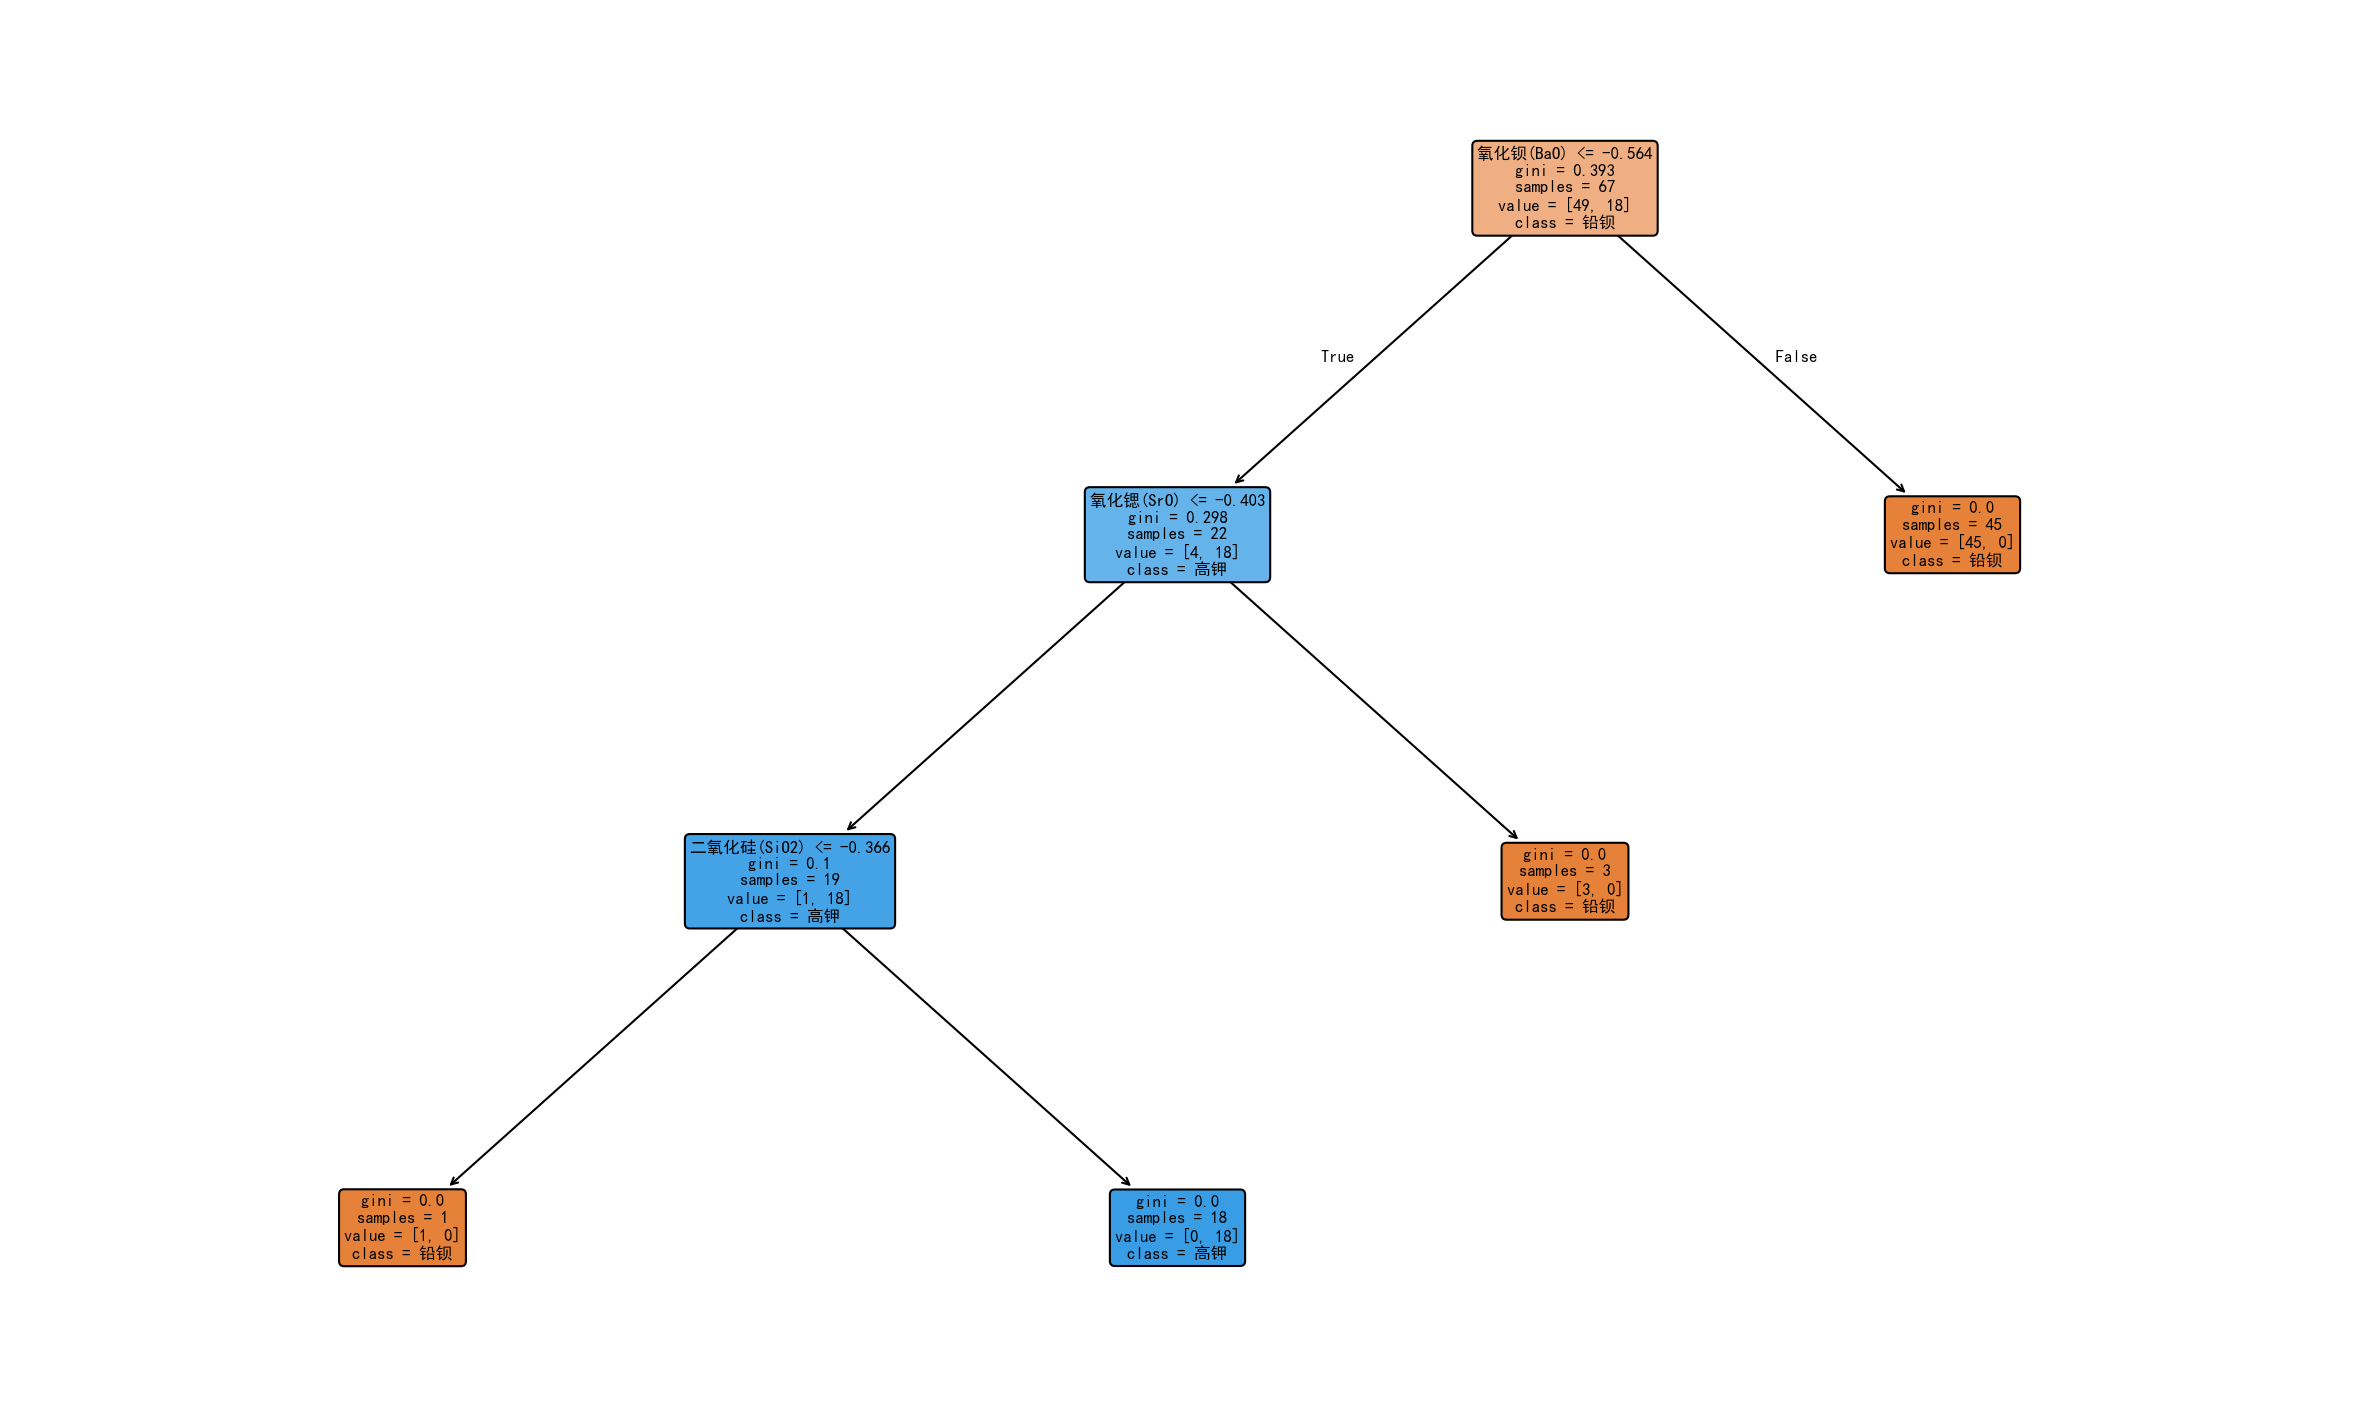

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# ==============================================================================
# 0. 环境准备
# ==============================================================================
print("--- 准备环境与数据 ---")
# 确保绘图能显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150 # 提高图片清晰度

# 加载数据
input_file = Path('../../Data/0/处理后的数据.xlsx')
output_dir = Path('./Result_P3_Final')
output_dir.mkdir(parents=True, exist_ok=True)
df_classified = pd.read_excel(input_file, sheet_name='已分类清洗后数据')

# 基本量化
le = LabelEncoder()
y_full = le.fit_transform(df_classified['类型'])
class_names = le.classes_.tolist() # ['铅钡', '高钾']

# ==============================================================================
# 1. 绘制包含PbO的“简单版”决策树
# ==============================================================================
print("\n--- 正在生成包含PbO的决策树图 ---")
# --- (1.1) 准备数据 (包含PbO) ---
features_to_remove_simple = ['氧化铝(Al2O3)', '氧化镁(MgO)', '氧化铁(Fe2O3)']
non_chemical_cols = ['文物编号', '文物采样点', '类型', '颜色', '纹饰', '表面风化', '成分总和']
chemical_columns = [col for col in df_classified.columns if col not in non_chemical_cols]
selected_features_simple = [col for col in chemical_columns if col not in features_to_remove_simple]

# 量化风化特征
weathering_one_hot = pd.get_dummies(df_classified['表面风化'], prefix='表面风化')
# 构建特征矩阵
X_full_simple_chem = df_classified[selected_features_simple]
X_full_simple = pd.concat([X_full_simple_chem, weathering_one_hot], axis=1)
# 标准化
scaler_simple = StandardScaler()
X_full_simple[selected_features_simple] = scaler_simple.fit_transform(X_full_simple[selected_features_simple])

# --- (1.2) 训练模型 ---
dt_simple = DecisionTreeClassifier(random_state=42)
dt_simple.fit(X_full_simple, y_full)

# --- (1.3) 绘图并保存 ---
plt.figure(figsize=(12, 8))
plot_tree(
    dt_simple,
    filled=True,
    feature_names=X_full_simple.columns.tolist(),
    class_names=class_names,
    rounded=True,
    fontsize=10,
    max_depth=2 # 只显示前2层以保持清晰
)
# 遵照您的要求，不添加顶部标题
# plt.title("决策树可视化 (包含 氧化铅(PbO))")
simple_tree_file = output_dir / '决策树图(含PbO).png'
plt.savefig(simple_tree_file, bbox_inches='tight')
print(f"“简单版”决策树图已保存至: '{simple_tree_file}'")


# ==============================================================================
# 2. 绘制不含PbO的“复杂版”决策树
# ==============================================================================
print("\n--- 正在生成不含PbO的决策树图 ---")
# --- (2.1) 准备数据 (不含PbO) ---
features_to_remove_complex = ['氧化铝(Al2O3)', '氧化镁(MgO)', '氧化铁(Fe2O3)', '氧化铅(PbO)']
selected_features_complex = [col for col in chemical_columns if col not in features_to_remove_complex]

# 构建特征矩阵
X_full_complex_chem = df_classified[selected_features_complex]
X_full_complex = pd.concat([X_full_complex_chem, weathering_one_hot], axis=1)
# 标准化
scaler_complex = StandardScaler()
X_full_complex[selected_features_complex] = scaler_complex.fit_transform(X_full_complex[selected_features_complex])

# --- (2.2) 训练模型 ---
dt_complex = DecisionTreeClassifier(random_state=42)
dt_complex.fit(X_full_complex, y_full)

# --- (2.3) 绘图并保存 ---
plt.figure(figsize=(20, 12))
plot_tree(
    dt_complex,
    filled=True,
    feature_names=X_full_complex.columns.tolist(),
    class_names=class_names,
    rounded=True,
    fontsize=8
)
# plt.title("决策树可视化 (不含 氧化铅(PbO))")
complex_tree_file = output_dir / '决策树图(不含PbO).png'
plt.savefig(complex_tree_file, bbox_inches='tight')
print(f"“复杂版”决策树图已保存至: '{complex_tree_file}'")
print("\n全部绘图工作完成。")